# Midterm SE 4460A
# Student ID: 250902000 <font color = 'red'> (XX / 100pts) </font>
## Student Name:  Jenna Wemple

## General comments 
This Midterm integrates knowledge and skills acquired in the first half of the semester, especially in the 6 Assignments. You are allowed to use any document and source on your computer and look up documents on the internet. **You or not allowed to share documents, or communicate in any other way with people inside or outside the classroom during the midterm.** To finish the midterm in the alloted 2 hrs (an additonal 20 minutes is given to download/upload the exam/solutions), you will have to work efficiently. **Read the entirety of each question carefully.**

* Students with last name starting A-D: please use **"Data_Rack01.csv"**
* Students with last name starting F-L: please use **"Data_Rack02.csv"**
* Students with last name starting M-N: please use **"Data_Rack03.csv"**
* Students with last name starting P-S: please use **"Data_Rack04.csv"**
* Students with last name starting T-Z: please use **"Data_Rack05.csv"**

### Additional Guidance

If at any point you are asking yourself "are we supposed to...", then *write your assumptions clearly in your exam and proceed according to those assumptions.*

Good luck!




In [81]:
## Preliminaries
# Sets up the environment by importing 
# pandas, numpy, matplotlib, and statsmodels.

### YOU MAY ADD ADDITIONAL IMPORTS IF YOU WISH

import matplotlib
import matplotlib.pyplot as plt 
%matplotlib inline
import pandas as pd 
import numpy as np
import seaborn as sns
#import statsmodels.api as sm

from sklearn.model_selection import train_test_split, cross_val_score,  GridSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.dummy import DummyRegressor
from sklearn.metrics import make_scorer, mean_absolute_error


---
## Data set 

This exam objective is to develop a data-driven predictive model for the power use of an industrial refrigeration system.  
The data frame contains the following data, where each row represents a datapoint:

- Dew_Point: the temperature to which air must be cooled to become saturated with water vapor 
- Indoor_Humidity: The indoor Humidity
- Indoor_Temperature: The indoor temprature (Fahrenheit)
- Outdoor_Humidity: The outdoor humidity
- Outdoor_Temperature: The outdoor temprature (Fahrenheit)
- Discharge_Pressure: The pressure generated on the output side of a gas compressor in a refrigeration system
- Discharge_Temperature: The compressor's discharge temperature 
- KW: Power consumed
- Power_Factor: The power factor of the refrigeration system
- Volts_Line_to_Line: voltage line to line
- Volts_Line_to_Neutral: line to neutral voltage




## Task 0: Data Preparation (5pts)

This task will focus on loading and pre-processing the data

In [60]:
# Load data, remove the empty column(s), 
# Then drop rows with any missing data ("NA").
# remove the 'DeviceName' column as well

data = pd.read_csv("Data_Rack05.csv")

#dropping columns
data = data.drop(["Outdoor_Humidity", "Discharge_Temperature", "DeviceName"], axis=1)
data = data.dropna(axis = 1, how = 'all')

print (data.head())

   Dew_Point  Indoor_Humidity  Indoor_Temperature  Outdoor_Temperature  \
0      52.66            51.18               70.65                95.14   
1      52.50            51.41               70.57                94.75   
2      52.86            51.48               70.57                94.75   
3      52.86            51.48               70.57                94.96   
4      52.16            50.71               70.57                94.96   

   Discharge_Pressure    kW  Power_Factor  Volts_Line_to_Line  \
0               283.8  33.1          0.73               607.5   
1               278.0  32.5          0.72               607.7   
2               285.0  31.8          0.71               608.0   
3               285.0  31.6          0.71               607.2   
4               279.6  31.1          0.71               608.2   

   Volts_Line_to_Neutral  
0                  350.1  
1                  350.1  
2                  350.3  
3                  349.9  
4                  350.5  



## Task 1: Prediction (75pts)

This task will focus on building predictive models for the power consumed based on the other available data.

### ---
### Question 1.1 - Visualizing the Outcome (4pts)

Produce a plot that visualizes the marginal distribution of the power consumed ('kW' column).

Text(0, 0.5, 'Power Consumed')

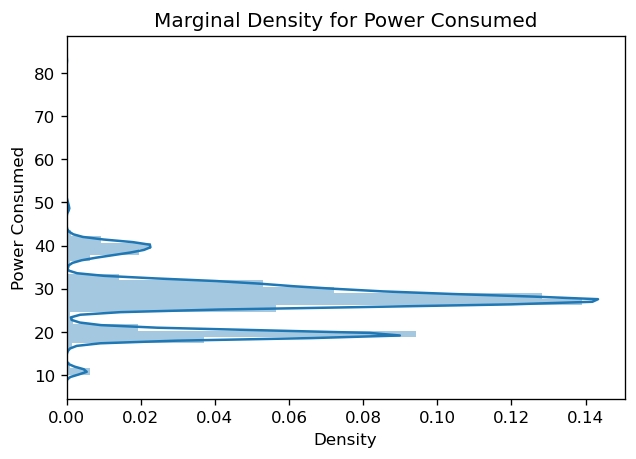

In [33]:
# Q1.1 - Code to produce plot

# Any plot of the marginal distribution is acceptable

y= data.kW.values
x = data.drop('kW', axis='columns').values

# Plot distribution  
fig, ax = plt.subplots(dpi = 120)
sns.distplot(y, vertical = True)

plt.title('Marginal Density for Power Consumed')
ax.set_xlabel('Density')
ax.set_ylabel('Power Consumed')


---
### Question 1.2 - Loss Functions (7pts)

Define two loss functions, one that measures the absolute difference between observations and predictions, and one that gives the mean number of instances for which the difference is less than or equal to a threshold `thresh`.

For example, if we had

obs = [1, 2, 3, 4, 5]
pred = [5, 4, 3, 2, 1]

Then threshold_loss(obs, pred, 2) should give 0.6


In [74]:
# Q1.2 - definitions of loss functions
def abs_diff(y, yp):
    return (np.abs(y-yp))

def threshold_loss(obs, pred, thresh):
    meandiff = (obs-pred)
    threshold_loss =sum( i <= thresh for i in meandiff)/meandiff.size
    return threshold_loss

# Check if you did it right
#need to send them as an array
obs = np.array([1, 2, 3, 4, 5]) 
pred = np.array([5, 4, 3, 2, 1]) 

print (threshold_loss(obs, pred, 2))

0.8


---
### Question 1.3 (7pts)

Suppose you are using the absolute loss. If you wanted to set a test set aside for evaluation, how much data should you allocate for testing if you want to evaluate the performance of our predictor to within +/- 1 units of loss with 95% confidence? Explain in 2 or 3 sentences the assumptions you used to compute the sample size. (There are several different approaches that are all acceptable.)

In [76]:
# Q1.3 - Computation to compute sample size for absolute difference
# Use the median as a prediction to get a 
# rough estimate of the noise

y_median= np.median(y)
abs_error = abs_diff(y, y_median)
std = abs_error.std()

d = 1 #Provided from question
test_size = (1.96*std/d)**2

print(test_size)

66.1840996884803


#### Q1.3 - Explanation

We can calcualte the expected test error on a new test set by using the confidence intervals equations and solving for n since we know the standard deviation value we would like to achieve on a 95 CI interval. An assumption I made for this was using the median as the prediction value, because median measures the central tendancy that is robust against outliers.

---
### Question 1.4 (7pts)

Suppose you are using the threshold loss with a cutoff of 5 KW to measure performance. If you wanted to set a test set aside for evaluation, how much data should you allocate for testing if you want to evaluate the performance of our predictor to within +/- 0.03 of the actual generalization performance with 95% confidence? Explain in 2 or 3 sentences the assumptions you used to compute the sample size. (There are several different approaches that are all acceptable.)

In [78]:
# Q1.4 - Computation to compute sample size for proportion below threshold
threshold = 5
y_median= np.median(y)
abs_error = threshold_loss(y, y_median, threshold)

d = 0.03 #Provided from question
test_size = (1.96*abs_error/d)**2

print(test_size)

3480.7924393298426


#### Q1.4 - Explanation

Again, one of the assumptions I made when i computed this was using the median because it is robust against outliers. Another assumption I made was using the absolute error in place as the standard deviation in my equation, because I wanted to take into account the threshold of 5, and it returns a whole number.


###### ---
### Question 1.5 - Test Split (8pts)

Set aside some amount of data for testing, and retain the rest for training. Choose whichever amount you want based on your previous answers, and state which one you used. **Use your Student ID number as the *random_state* parameter value.**


In [79]:
# Q1.5 - Code to set aside data

xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=66, random_state=250902000)


I decided to use the test size determined by absolute error which was the  66, because I don't want to use too many and make sure I have enough for saved for training

### ---
### Question 1.6 - Simple Linear Model (5pts)

Using Ordinary Least Squares, build a model to predict power consumed (KW) as a linear function of the other variables in the data.


In [37]:
# Q1.6 - Code to produce simple OLS model
model_OLS = LinearRegression().fit(xtrain, ytrain)
yp = model_OLS.predict(xtrain)

#fig, ax = plt.subplots(dpi = 120)
#sns.distplot(xtrain, yp)
# Add the line to the graph 
#plt.plot(xtrain, yp, color='red')


---
### Question 1.7 - More Complex Model (8pts)

Again using Ordinary Least Squares, develop second a model that has lower training error than the simple model.

In [52]:
# Q1.7 - Code to produce more complex OLS model
poly = PolynomialFeatures(degree = 2)
pipe_model_P = Pipeline(steps = [('poly', poly),('Standardize', StandardScaler()), ('linear reg', LinearRegression())])
model_P = pipe_model_P.fit(xtrain, ytrain)

### Question 1.8 - Model Selection (10pts)

Use cross-validation to compare the two model spaces to select the one you think will result in the smallest generalization error for one of the loss functions you defined above. (Either one.) Explain why you chose the particular model space. 


In [80]:
# Q1.8 - Code to do cross-validation to compare models
#kf = KFold(n_splits=5,shuffle=False)
def abs_diff_mean(y, yp):
    return np.mean(np.abs(y-yp))

sc = make_scorer(abs_diff_mean)
#sc = make_scorer(threshold_loss)

cv_scores1_LR = cross_val_score(model_OLS, xtrain, ytrain, cv=5, scoring=sc)
cv_scores2_P = cross_val_score(model_P, xtrain, ytrain, cv=5, scoring=sc)

print(f"CV score: {cv_scores1_LR}")
print(f"CV loss: {cv_scores1_LR.mean()}")

print(f"CV score: {cv_scores2_P}")
print(f"CV loss: {cv_scores2_P.mean()}")

CV score: [2.13669555 2.04528284 2.12442992 2.1460516  2.18924925]
CV loss: 2.1283418291832086
CV score: [1.62685437 1.54074043 1.5945994  1.64494308 1.64424376]
CV loss: 1.6102762105530115


#### Q1.8 - Explanation


I choose to use this particular because the function Poly, because I don't want to overfit my data and ensure I have the correct bias-variance in my model, by only using degree =2. This then results in a much lower CV loss than my OLS model and verifies that it is working correctly

---
### Question 1.9 - Evaluation, Absolute Value, Normal approximation confidence interval (8pts)

Provide a point estimate for the generalization error of your chosen model using the absolute difference loss. Also provide a 95% confidence interval for the true generalization error under this loss. Construct the interval using a normal approximation.

Generalization Error:  1.5757712584905739
Confidence interval:  [1.51314634 1.63839618]


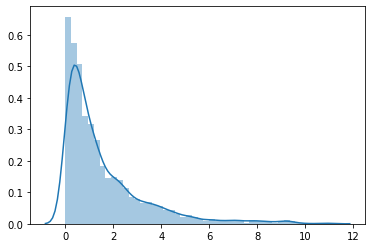

In [55]:
# Q1.9 Evaluation - Absolute Value Loss - Use normal approximation
#Predict on the test set
yp = model_P.predict(xtest)

#Compute the errors and a point estimate of the generalization error
test_errors = np.abs(ytest - yp)
generalization_error = abs_diff(ytest, yp)

#Construct a confidence interval
# We have enough data in our test set that the appropirate t-quantile is close to 1.96
test_ci = generalization_error + 1.96 * np.std(test_errors) / np.sqrt(len(test_errors)) * np.array([-1, 1])

sns.distplot(abs(test_errors))

print('Generalization Error: ',generalization_error)
print('Confidence interval: ', test_ci)


---
### Question 1.10 - Evaluation, Threshold, Bootstrap approximation confidence interval (11pts)

Provide a point estimate for the generalization error of your model using the threshold loss with a threshold of 4. Also provide a 95% confidence interval for the true generalization error under this loss. Construct the interval using the bootstrap.

In [59]:
# Q1.10 Evaluation - Threshold Loss - Use bootstrap

# Write a Bootstrap function that records the fitted models 
def BootstrapCoef(data,numboot=1000):
    regr = LinearRegression()
    n = len(data)
    theta = np.zeros((numboot,2))    
    for i in range(numboot):
        d = data.sample(n, replace=True)
        X_fit = np.c_[xtest]
        regr.fit(X_fit,ytest)
        #regr.fit(xtest,ytest)
        theta[i,0]=regr.intercept_
        theta[i,1]=regr.coef_
    return theta

params = BootstrapCoef(data,100)

generalization_error = threshold_loss(ytest, yp, 4)

bs_res = params[:,1]-generalization_error
plt.hist(params[:,1], edgecolor = 'white', density=True)
ci_lower, ci_upper = np.quantile(bs_res, [0.025, 0.975])
boot_ci = [generalization_error - ci_upper, 
           generalization_error - ci_lower]

print('My confidence interval is between', boot_ci[0], ' and ', boot_ci[1])

print('Generalization Error: ',generalization_error)
print('Confidence interval: ', boot_ci)


ValueError: setting an array element with a sequence.

---
---
## Task 2 - Regularized Linear Regression Model

---
### Question 2.1 (10 pts)  

Use L1 regularization to determine the best set of variables to include in a predictive model. Add a penalty of $\lambda \sum_{i}{|\beta_i|_1}$ ($\beta_i$ are your regression coefficients) to the linear regression model. Vary the regularization parameter $\lambda$ between 0.2 and 200, evenly spaced in log-space.

Apply all necessary preprocessing steps to your variables to be able to compare meaningfully between different predictors in the model.

Plot the coefficient path, i.e. the size of the regression coefficients relative to the size of the the regularization paramter. Which two variables are the two most important predictors?

{'alpha': array([1.22140276e+00, 3.33349099e+00, 9.09786892e+00, 2.48301912e+01,
       6.77673423e+01, 1.84952771e+02, 5.04778946e+02, 1.37765865e+03,
       3.75994949e+03, 1.02617729e+04, 2.80067549e+04, 7.64369201e+04,
       2.08614057e+05, 5.69356074e+05, 1.55390458e+06, 4.24096547e+06,
       1.15745769e+07, 3.15897010e+07, 8.62156099e+07, 2.35302366e+08,
       6.42194651e+08, 1.75269793e+09, 4.78351855e+09, 1.30553299e+10,
       3.56310189e+10, 9.72453023e+10, 2.65404951e+11, 7.24351576e+11,
       1.97692320e+12, 5.39548126e+12, 1.47255179e+13, 4.01893486e+13,
       1.09686040e+14, 2.99358604e+14, 8.17018960e+14, 2.22983395e+15,
       6.08573327e+15, 1.66093755e+16, 4.53308322e+16, 1.23718339e+17,
       3.37656000e+17, 9.21541421e+17, 2.51509996e+18, 6.86429025e+18,
       1.87342378e+19, 5.11300736e+19, 1.39545812e+20, 3.80852838e+20,
       1.03943560e+21, 2.83686047e+21, 7.74244920e+21, 2.11309369e+22,
       5.76712206e+22, 1.57398117e+23, 4.29575913e+23, 1.17241215e+

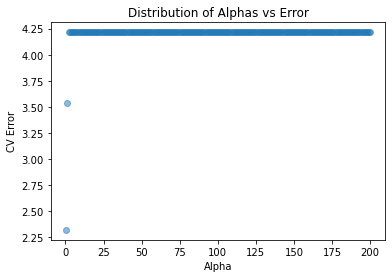

In [68]:
# Q 2.1
# Systematically vary the ridge coeficient on a log-scale
lam = np.exp(np.linspace(0.2,200,200))
mse = np.zeros(200)

sc = make_scorer(abs_diff)
#'neg_mean_squared_error'

for i in range(lam.size):
    cv_scores = cross_val_score(Pipeline([('Scaler', StandardScaler()),('Lasso', Lasso(alpha=lam[i]))]), xtrain, ytrain, cv=10,scoring = sc)
    mse[i]=cv_scores.mean()
    
# Determine lowest value 
plt.scatter(np.log(lam),mse, alpha = 0.5)
plt.title('Distribution of Alphas vs Error') #adding a title to the plot
plt.xlabel("Alpha") #x axis label
plt.ylabel("CV Error") #y axis label

#determine the best regualarization parameter
parameters = {'alpha': lam}
rrmodel = GridSearchCV(Lasso(),parameters,cv =10, scoring =sc)
rrmodel.fit(xtrain, ytrain)

print(parameters)
#print(rrmodel.best_params_)
#print(rrmodel.best_score_)


#### Q2.1 - Explanation

The two most important predictators are the two shown in the diagram that are below the line with an alpha of 1.22 and 3.33. These are the most important because they have the lowest cross-validation error. 

---
### Question 2.2 (10 pts)

Using the same model and the range of regularisation parameters as in T2, Q1, determine the 10-fold crossvalidated performance for different values of the L1-regularisation parameter. 

Make a plot of the crossvalidated score against $log(\lambda)$. Based on this criterion, what is the optional setting of the L1-regularization parameter? At this value, which variables contribute to the prediction?

In [83]:
# Q 2.2
kf = KFold(n_splits=10,shuffle=False)
sc = make_scorer(abs_diff_mean)
lam = np.exp(np.linspace(0.2,200,200))
mse = np.zeros(200)
#using best
for i in range(lam.size):
    cv_scores1 = cross_val_score(Pipeline([('Scaler', StandardScaler()),('Lasso', Lasso(alpha=lam[1.22]))]), xtrain, ytrain, cv=kf, scoring=sc)
    mse[i]=cv_scores.mean()
    
plt.scatter(np.log(1.22),mse, alpha = 0.5)
plt.title('Distribution of Alphas vs Error') #adding a title to the plot
plt.xlabel("Alpha") #x axis label
plt.ylabel("CV Error") #y axis label

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

#### Q2.2 - Answer


*Write your explanation here*

The optimal setting of the L1 regualarization is alpha of 1.22 because it has the lowest CV score

At this value, values that contriubute to the prediction include all features except the ones we dropped. And any that were minimized to zero by the Lasso that were considered insignifcant. 